<a href="https://colab.research.google.com/github/uless/chatbot-equity/blob/main/stance_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

Reference:


Using Machine Learning to Measure User Sentiment towards Climate Change: https://edwardcqian.medium.com/using-machine-learning-to-measure-user-sentiment-towards-climate-change-d817c21c5887

GitHub Repo: https://github.com/edwardcqian/climate_change_sentiment

In [ ]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip && unzip glove.twitter.27B.zip

In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip && unzip glove.42B.300d.zip

--2022-08-19 16:52:12--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2022-08-19 16:52:13--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2022-08-19 16:52:13--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import numpy as np
from nltk.corpus import stopwords 

# clean up given string
def clean_text(raw): 
    # Remove link
    raw = re.sub(r'http\S+', '', raw)
    # Remove unexpected artifacts
    raw = re.sub(r'â€¦', '', raw)
    raw = re.sub(r'…', '', raw)
    raw = re.sub(r'â€™', "'", raw)
    raw = re.sub(r'â€˜', "'", raw)
    raw = re.sub(r'\$q\$', "'", raw)
    raw = re.sub(r'&amp;', "and", raw)
    # remove non valid characters
    raw = re.sub('[^A-Za-z0-9#@ ]+', "", raw)
    words = raw.split()  

    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    return( " ".join(words))

# create onehot representation of the label
def get_onehot(arr, num_class):
    return np.eye(num_class)[np.array(arr).reshape(-1)]

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding,SpatialDropout1D, Bidirectional, GRU
from keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
data = pd.read_csv('sample_data.csv')
data = data.dropna(subset=['message']) # remove any empty tweets

# cleaning the raw text data
data['message'] = data['message'].apply(clean_text)

# remove duplicates from data
data = data.drop_duplicates(subset=['message'])

In [ ]:
data = data.replace(-1, 0)
data = data.replace(2, 0)
data.head()

,sentiment,message,tweetid
0,0,@tiniebeany climate change interesting hustle ...,792927353886371840
1,1,RT @NatGeoChannel Watch #BeforeTheFlood right ...,793124211518832641
2,1,Fabulous Leonardo #DiCaprios film #climate cha...,793124402388832256
3,1,RT @MickFanning Just watched amazing documenta...,793124635873275904
4,0,RT @cnalive Pranita Biswasi Lutheran Odisha gi...,793125156185137153


In [ ]:

# isolate label and text
y = data['sentiment']
y += 1
X_data = data['message']

# splitting into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size= 0.1, random_state = 1)

# Setup model parameters
EMBEDDING_FILE = "glove.twitter.27B.200d.txt" # path to embedding file 
max_features = 20000                           # we are only interested in top 50k most frequently used words
maxlen = 150                                   # tweets longer than 150 words will be truncated otherwise padded
embed_size = 200                               # size of each vector (must match the size of the glove embedding)

# tokenize training and testing data
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_tr = tokenizer.texts_to_sequences(X_train)
X_tr = sequence.pad_sequences(X_tr, maxlen=maxlen)
X_ts = tokenizer.texts_to_sequences(X_test)
X_ts = sequence.pad_sequences(X_ts, maxlen=maxlen)

# loading the embedding file (may take some time)
embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
  for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

word_index = tokenizer.word_index

# prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
  if i >= max_features:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
  
y_tr_one = get_onehot(y_train, 4)
y_ts_one = get_onehot(y_test, 4) 

# creating the model
gru_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(gru_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, reset_after=True, recurrent_activation='sigmoid'))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
gru_output = Dense(4, activation="sigmoid")(x)
gru_model = Model(gru_input, gru_output)
gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# training parameters
epochs = 20 
batch_size = 128
patience = 4    # for early stopping
file_path="weights/gru_final.hdf5" # where to save the best model weights

# creating checkpoint to save the model
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)
callbacks_list = [checkpoint, early] #early

# training the model
gru_model.fit(X_tr, y_tr_one, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

# loading the best weights
gru_model.load_weights(file_path)


Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.6619
Epoch 1: val_loss improved from inf to 0.54308, saving model to weights/gru_final.hdf5
251/251 [==============================] - 251s 980ms/step - loss: 0.6141 - accuracy: 0.6619 - val_loss: 0.5431 - val_accuracy: 0.7260
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.7285
Epoch 2: val_loss improved from 0.54308 to 0.51847, saving model to weights/gru_final.hdf5
251/251 [==============================] - 243s 967ms/step - loss: 0.5381 - accuracy: 0.7285 - val_loss: 0.5185 - val_accuracy: 0.7426
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.7537
Epoch 3: val_loss did not improve from 0.51847
251/251 [==============================] - 249s 992ms/step - loss: 0.5015 - accuracy: 0.7537 - val_loss: 0.5252 - val_accuracy: 0.7395
Epoch 4/20
251/251 [==============================] - ETA: 0s - loss: 0.4724 - acc

In [ ]:
# predicting on testing set
class_prob = gru_model.predict(X_ts)
class_pred = np.argmax(class_prob,axis=1)

# some basic metrics for accuracy
print('accuracy score: ' + str(accuracy_score(y_test,class_pred)))
classes = ['Not Support','Support']

accuracy score: 0.7642893272635306


In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

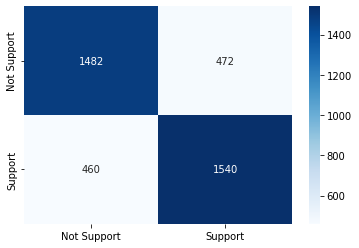

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,class_pred)
cm = cm/cm.astype(np.float).sum(axis=1)

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

In [ ]:
cm = confusion_matrix(y_test,class_pred)
cm

array([[1482,  472],
       [ 460, 1540]])

In [ ]:
TP = 1540
FP = 472
TN = 1482
FN = 460

prec = TP / (FP + TP)
recall = TP / (FN + TP)
accu = (TP + TN)/(TP + FN + TN + FP)
f1= 2* prec * recall/(prec + recall)

print('Precision Score: %.3f' % prec, 
      'Recall Score: %.3f' % recall, 
      'Accuracy Score: %.3f' %accu, 
      'F1 Score: %.3f' %f1 )

Precision Score: 0.765 Recall Score: 0.770 Accuracy Score: 0.764 F1 Score: 0.768


In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df_human = pd.read_csv("compare_cc_human.csv")
df_bot = pd.read_csv("compare_cc_bot.csv")

In [ ]:
df_human

In [ ]:
cm = confusion_matrix(df_human["stancehuman"],df_human["stancemachine"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


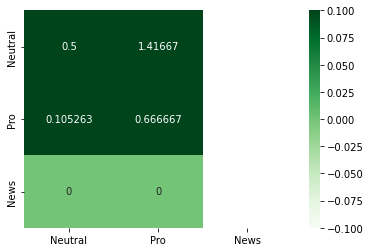

In [ ]:
cm = confusion_matrix(df_human["stancehuman"],df_human["stancemachine"])
cm = cm/cm.astype(np.float).sum(axis=1)
classes = ['Neutral','Pro',"News"]
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
sn.heatmap(df_cm, annot=True,cmap='Greens', fmt='g')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


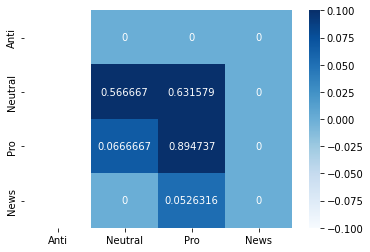

In [ ]:
cm = confusion_matrix(df_bot["stancehuman"],df_bot["stancemachine"])
cm = cm/cm.astype(np.float).sum(axis=1)
classes = ["Anti",'Neutral','Pro',"News"]
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


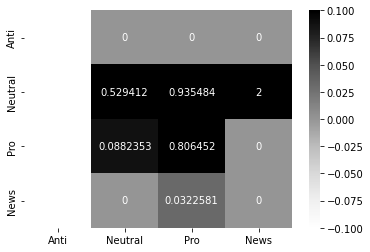

In [ ]:
df = 	pd.concat([df_human,df_bot])
cm = confusion_matrix(df["stancehuman"],df["stancemachine"])
cm = cm/cm.astype(np.float).sum(axis=1)
classes = ["Anti",'Neutral','Pro',"News"]
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
sn.heatmap(df_cm, annot=True,cmap='Greys', fmt='g')

In [ ]:
cm

array([[19, 17,  2],
       [ 4,  8,  0],
       [ 0,  0,  0]])

# Stance detection

In [ ]:
cc_human = pd.read_csv("conv_cc_human.csv",encoding = 'latin1')
cc_human = cc_human.dropna(subset=['text']) # remove any empty tweets

# cleaning the raw text data
cc_human['text'] = cc_human['text'].apply(clean_text)

In [ ]:
cc_human

,Unnamed: 0,index,round,text
0,1,1,1,HI
1,2,1,2,Information climate change GPT3
2,3,1,3,Nice one
3,4,1,4,meet
4,5,1,5,GPT3
...,...,...,...,...
13562,13563,3290,3,Ive read scientific articles provided results ...
13563,13564,3290,4,Yes studied many many years It risen much incr...
13564,13565,3290,5,No I think humans
13565,13566,3290,6,I think humans adapt extremely intelligent bei...


In [ ]:
X_cc_human = cc_human['text']

In [ ]:
tokenizer_c = text.Tokenizer(num_words=max_features)
tokenizer_c.fit_on_texts(list(X_cc_human))

X_ch = tokenizer_c.texts_to_sequences(X_cc_human)
X_ch = sequence.pad_sequences(X_ch, maxlen=maxlen)

In [ ]:
class_prob_h = gru_model.predict(X_ch)
class_pred_h = np.argmax(class_prob_h,axis=1)
class_pred_h -=1

In [ ]:
class_prob_h

array([[0.48091224, 0.87667316, 0.6682139 , 0.03436309],
       [0.46384308, 0.66460884, 0.8470319 , 0.04917306],
       [0.45612434, 0.8026633 , 0.63968885, 0.06957769],
       ...,
       [0.3363767 , 0.6422151 , 0.8860096 , 0.05283859],
       [0.256205  , 0.5171993 , 0.46064472, 0.76787394],
       [0.48637185, 0.8540969 , 0.5454031 , 0.09108958]], dtype=float32)

In [ ]:
df_class_prob_h = pd.DataFrame(class_prob_h, columns = ['Against','Neutral','Support','News'])

In [ ]:
cc_human['stance'] = class_pred_h.tolist()
cc_human = pd.concat([cc_human, df_class_prob_h], axis=1)
cc_human.head(n=10)

,Unnamed: 0,index,round,text,stance,Against,Neutral,Support,News
0,1,1,1,HI,0,0.480912,0.876673,0.668214,0.034363
1,2,1,2,Information climate change GPT3,1,0.463843,0.664609,0.847032,0.049173
2,3,1,3,Nice one,0,0.456124,0.802663,0.639689,0.069578
3,4,1,4,meet,0,0.309658,0.836184,0.680057,0.108761
4,5,1,5,GPT3,1,0.307319,0.765460,0.808475,0.082975
5,6,1,6,SUPER,0,0.390838,0.739132,0.582277,0.291611
6,7,3,1,Hello,1,0.402205,0.679367,0.723462,0.235644
7,8,3,2,W,2,0.247414,0.461087,0.546365,0.675888
8,9,3,3,Gan guo,1,0.453341,0.685455,0.897402,0.037139
9,10,3,4,What opinion climate change,0,0.245465,0.746724,0.379336,0.591220


In [ ]:
cc_human.to_csv("cc_human_machinecode.csv")

In [ ]:
def countFreq(arr, n):
  
    mp = dict()
  
    # Traverse through array elements 
    # and count frequencies
    for i in range(n):
        if arr[i] in mp.keys():
            mp[arr[i]] += 1
        else:
            mp[arr[i]] = 1
              
    # Traverse through map and print 
    # frequencies
    for x in mp:
        print(x, " ", mp[x])

In [ ]:
n = len(class_pred_h)
countFreq(class_pred_h, n)

0   6107
1   5326
2   1528
-1   606


In [ ]:
cc_bot = pd.read_csv("conv_cc_bot.csv",encoding = 'latin1')
cc_bot = cc_bot.dropna(subset=['text']) # remove any empty tweets

# cleaning the raw text data
cc_bot['text'] = cc_bot['text'].apply(clean_text)

X_cc_bot = cc_bot['text']

X_cb = tokenizer.texts_to_sequences(X_cc_bot)
X_cb = sequence.pad_sequences(X_cb, maxlen=maxlen)

class_prob_b = gru_model.predict(X_cb)
class_pred_b = np.argmax(class_prob_b,axis=1)
class_pred_b -=1

cc_bot['stance'] = class_pred_b.tolist()
cc_bot.head()

,Unnamed: 0,index,round,text,stance
0,1,1,1,Hello I AI assistant What I today,0
1,2,1,2,Climate change longterm change average weather...,1
2,3,1,3,Thanks,1
3,4,1,4,Please come,1
4,5,1,5,U00A0Graphene Photonics Technology Ltd GPT pub...,1


In [ ]:
n = len(class_pred_b)
countFreq(class_pred_b, n)

0   6288
1   6731
2   240
-1   308


In [ ]:
cc_bot['stance'] = class_pred_b.tolist()
df_class_prob_b = pd.DataFrame(class_prob_b, columns = ['Against','Neutral','Support','News'])
cc_bot = pd.concat([cc_bot, df_class_prob_b], axis=1)
cc_bot.head(n=15)

,Unnamed: 0,index,round,text,stance,Against,Neutral,Support,News
0,1,1,1,Hello I AI assistant What I today,0,0.400376,0.905236,0.731137,0.020632
1,2,1,2,Climate change longterm change average weather...,1,0.296557,0.620093,0.915974,0.049308
2,3,1,3,Thanks,1,0.428698,0.800082,0.806519,0.049759
3,4,1,4,Please come,1,0.507504,0.772138,0.814118,0.026436
4,5,1,5,U00A0Graphene Photonics Technology Ltd GPT pub...,1,0.038317,0.895649,0.959336,0.056321
5,6,1,6,Thank,0,0.529376,0.815375,0.774671,0.034807
6,7,3,1,Hello I AI assistant What I today,0,0.400376,0.905236,0.731137,0.020632
7,8,3,2,What name type spicy food China,0,0.248847,0.822610,0.623812,0.208153
8,9,3,3,Exactly right,0,0.413782,0.850248,0.738093,0.056783
9,10,3,4,I really understand The environment around doe...,1,0.420539,0.626350,0.910656,0.030992


In [ ]:
cc_bot.to_csv("cc_bot_machinecode.csv")

# Stance detection for the mixed dataset

In [ ]:
cc = pd.read_csv("cc_manualcoding.csv",encoding = 'latin1')
cc = cc.dropna(subset=['text']) # remove any empty tweets

# cleaning the raw text data
cc['text'] = cc['text'].apply(clean_text)

In [ ]:
X_cc = cc['text']
tokenizer_c = text.Tokenizer(num_words=max_features)
tokenizer_c.fit_on_texts(list(X_cc))

X_ch = tokenizer_c.texts_to_sequences(X_cc)
X_ch = sequence.pad_sequences(X_ch, maxlen=maxlen)

class_prob_h = gru_model.predict(X_ch)
class_pred_h = np.argmax(class_prob_h,axis=1)
class_pred_h -=1

In [ ]:
cc['stance'] = class_pred_h.tolist()
cc.head()

,text,pro,stance
0,,0,0
1,please briefly explained,0,1
2,I afraid children especially grandchildren,0,0
3,United States getting hotter,1,1
4,hi,0,0


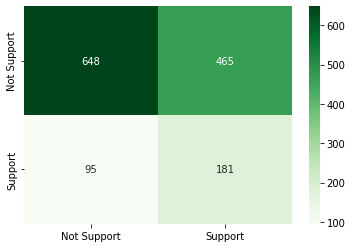

In [ ]:
cm = confusion_matrix(cc['pro'],cc['stance'])
#cm = cm/cm.astype(np.float).sum(axis=1)

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
sn.heatmap(df_cm, annot=True,cmap='Greens', fmt='g')

In [ ]:
cm

array([[648, 465],
       [ 95, 181]])

In [ ]:
TP = 181
FP = 465
TN = 648
FN = 95

prec = TP / (FP + TP)
recall = TP / (FN + TP)
accu = (TP + TN)/(TP + FN + TN + FP)
f1= 2* prec * recall/(prec + recall)

print('Precision Score: %.3f' % prec, 
      'Recall Score: %.3f' % recall, 
      'Accuracy Score: %.3f' %accu, 
      'F1 Score: %.3f' %f1 )

Precision Score: 0.280 Recall Score: 0.656 Accuracy Score: 0.597 F1 Score: 0.393


# Training our own model

In [ ]:
cc = pd.read_csv("cc_manualcoding.csv",encoding = 'latin1')
cc = cc.dropna(subset=['text']) # remove any empty tweets

# cleaning the raw text data
cc['text'] = cc['text'].apply(clean_text)

In [ ]:
cc.head()

,text,pro
0,,0
1,please briefly explained,0
2,I afraid children especially grandchildren,0
3,United States getting hotter,1
4,hi,0


In [ ]:
# isolate label and text
y = cc['pro']
#y += 1
X_data = cc['text']

# splitting into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size= 0.1, random_state = 1)

# Setup model parameters
EMBEDDING_FILE = "glove.42B.300d.txt" # path to embedding file 
max_features = 2500                           # we are only interested in top 50k most frequently used words
maxlen = 150                                   # tweets longer than 150 words will be truncated otherwise padded
embed_size = 300                               # size of each vector (must match the size of the glove embedding)

# tokenize training and testing data
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_tr = tokenizer.texts_to_sequences(X_train)
X_tr = sequence.pad_sequences(X_tr, maxlen=maxlen)
X_ts = tokenizer.texts_to_sequences(X_test)
X_ts = sequence.pad_sequences(X_ts, maxlen=maxlen)

# loading the embedding file (may take some time)
embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
  for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

word_index = tokenizer.word_index

In [ ]:
y_train

854     0
288     0
115     0
763     0
614     0
       ..
715     0
905     1
1096    0
235     0
1061    0
Name: pro, Length: 1250, dtype: int64

In [ ]:
y_test

255     0
435     0
1240    0
724     0
653     0
       ..
720     0
1029    1
159     0
561     0
169     0
Name: pro, Length: 139, dtype: int64

In [ ]:
np.array(y_test).reshape(-1)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0])

In [ ]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [ ]:
np.eye(2)[np.array(y_test).reshape(-1)]

In [ ]:
np.eye(num_class)[np.array(arr).reshape(-1)]

In [ ]:
# prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
  if i >= max_features:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

In [ ]:
y_tr_one = get_onehot(y_train,2)
y_ts_one = get_onehot(y_test,2) 

In [ ]:
# creating the model
gru_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(gru_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, reset_after=True, recurrent_activation='sigmoid'))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
gru_output = Dense(2, activation="sigmoid")(x)
gru_model = Model(gru_input, gru_output)
gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# training parameters
epochs = 20 
batch_size = 128
patience = 4    # for early stopping
file_path="weights/gru_final.hdf5" # where to save the best model weights

# creating checkpoint to save the model
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)
callbacks_list = [checkpoint, early] #early

# training the model
gru_model.fit(X_tr, y_tr_one, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

# loading the best weights
gru_model.load_weights(file_path)


Epoch 1/20
9/9 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.7902
Epoch 1: val_loss improved from inf to 0.45953, saving model to weights/gru_final.hdf5
9/9 [==============================] - 16s 1s/step - loss: 0.5400 - accuracy: 0.7902 - val_loss: 0.4595 - val_accuracy: 0.8000
Epoch 2/20
9/9 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.8622
Epoch 2: val_loss improved from 0.45953 to 0.40067, saving model to weights/gru_final.hdf5
9/9 [==============================] - 10s 1s/step - loss: 0.3719 - accuracy: 0.8622 - val_loss: 0.4007 - val_accuracy: 0.8400
Epoch 3/20
9/9 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.8818
Epoch 3: val_loss improved from 0.40067 to 0.34423, saving model to weights/gru_final.hdf5
9/9 [==============================] - 10s 1s/step - loss: 0.2938 - accuracy: 0.8818 - val_loss: 0.3442 - val_accuracy: 0.8800
Epoch 4/20
9/9 [==============================] - ETA: 0s - loss: 0.2668 -

In [ ]:
class_prob = gru_model.predict(X_ts)
class_pred = np.argmax(class_prob,axis=1)

cm = confusion_matrix(y_test,class_pred)
cm

array([[100,   7],
       [  9,  23]])

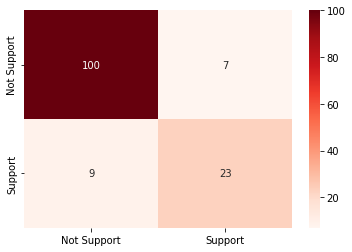

In [ ]:
classes = ['Not Support','Support']
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
sn.heatmap(df_cm, annot=True,cmap='Reds', fmt='g')

In [ ]:
TP = 23
FP = 7
TN = 100
FN = 9

prec = TP / (FP + TP)
recall = TP / (FN + TP)
accu = (TP + TN)/(TP + FN + TN + FP)
f1= 2* prec * recall/(prec + recall)

print('Precision Score: %.3f' % prec, 
      'Recall Score: %.3f' % recall, 
      'Accuracy Score: %.3f' %accu, 
      'F1 Score: %.3f' %f1 )

Precision Score: 0.767 Recall Score: 0.719 Accuracy Score: 0.885 F1 Score: 0.742


# Using our trained model

In [ ]:
cc_human = pd.read_csv("conv_cc_human.csv",encoding = 'latin1')
cc_human = cc_human.dropna(subset=['text']) # remove any empty

# cleaning the raw text data
cc_human['text'] = cc_human['text'].apply(clean_text)

In [ ]:
cc_human

,Unnamed: 0,mod,index,round,text
0,1,1,1,1,HI
1,2,2,1,2,Information climate change GPT3
2,3,3,1,3,Nice one
3,4,4,1,4,meet
4,5,5,1,5,GPT3
...,...,...,...,...,...
13562,13563,163,3290,3,Ive read scientific articles provided results ...
13563,13564,164,3290,4,Yes studied many many years It risen much incr...
13564,13565,165,3290,5,No I think humans
13565,13566,166,3290,6,I think humans adapt extremely intelligent bei...


In [ ]:
X_cc_human = cc_human['text']
tokenizer_c = text.Tokenizer(num_words=max_features)
tokenizer_c.fit_on_texts(list(X_cc_human))

X_ch = tokenizer_c.texts_to_sequences(X_cc_human)
X_ch = sequence.pad_sequences(X_ch, maxlen=maxlen)

class_prob_h = gru_model.predict(X_ch)
class_pred_h = np.argmax(class_prob_h,axis=1)
#class_pred_h -=1

In [ ]:
class_prob_h

array([[0.88665783, 0.08692127],
       [0.6765232 , 0.33132154],
       [0.6323309 , 0.3480988 ],
       ...,
       [0.8037473 , 0.1655345 ],
       [0.36706567, 0.66264397],
       [0.8952956 , 0.06770167]], dtype=float32)

In [ ]:
class_pred_h

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
df_class_prob_h = pd.DataFrame(class_prob_h, columns = ['Not support','Support'])

cc_human['stance'] = class_pred_h.tolist()
cc_human = pd.concat([cc_human, df_class_prob_h], axis=1)
cc_human.head(n=10)

cc_human.to_csv("cc_human_machinecode.csv")

In [ ]:
cc_human.tail(n=10)

,Unnamed: 0,mod,index,round,text,stance,Not support,Support
13557,13558,158,3288,6,Will loss human life,0,0.883522,0.090016
13558,13559,159,3288,7,sounds little dramatic,0,0.619866,0.386899
13559,13560,160,3288,8,tipping point,0,0.905925,0.068145
13560,13561,161,3290,1,I believe climate change happening future gene...,1,0.407483,0.575991
13561,13562,162,3290,2,There always difference opinion people science...,0,0.765694,0.167399
13562,13563,163,3290,3,Ive read scientific articles provided results ...,0,0.760911,0.173159
13563,13564,164,3290,4,Yes studied many many years It risen much incr...,1,0.325185,0.637079
13564,13565,165,3290,5,No I think humans,0,0.803747,0.165534
13565,13566,166,3290,6,I think humans adapt extremely intelligent bei...,1,0.367066,0.662644
13566,13567,167,3290,7,Youre welcome,0,0.895296,0.067702


In [ ]:
class_prob_h

array([[0.88665783, 0.08692127],
       [0.6765232 , 0.33132154],
       [0.6323309 , 0.3480988 ],
       ...,
       [0.8037473 , 0.1655345 ],
       [0.36706567, 0.66264397],
       [0.8952956 , 0.06770167]], dtype=float32)

In [ ]:
cc_bot = pd.read_csv("conv_cc_bot.csv",encoding = 'latin1')
cc_bot = cc_bot.dropna(subset=['text']) # remove any empty

# cleaning the raw text data
cc_bot['text'] = cc_bot['text'].apply(clean_text)

X_cc_bot = cc_bot['text']
tokenizer_c = text.Tokenizer(num_words=max_features)
tokenizer_c.fit_on_texts(list(X_cc_bot))

X_ch = tokenizer_c.texts_to_sequences(X_cc_bot)
X_ch = sequence.pad_sequences(X_ch, maxlen=maxlen)

class_prob_h = gru_model.predict(X_ch)
class_pred_h = np.argmax(class_prob_h,axis=1)
class_pred_h -=1

df_class_prob_h = pd.DataFrame(class_prob_h, columns = ['Not support','Support'])

cc_bot['stance'] = class_pred_h.tolist()
cc_bot = pd.concat([cc_bot, df_class_prob_h], axis=1)
cc_bot.head(n=10)

cc_bot.to_csv("cc_bot_machinecode.csv")

In [ ]:
cc_bot.tail()

,Unnamed: 0,index,round,text,stance,Not support,Support
13562,13563,3290,3,In view temperature risen somewhat year How mu...,-1,0.537182,0.502918
13563,13564,3290,4,You think people die heat exhaustion similar c...,0,0.470729,0.508261
13564,13565,3290,5,Okay thank time To assist please respond infor...,-1,0.608900,0.340587
13565,13566,3290,6,You need provide additional information belief...,-1,0.651269,0.381590
13566,13567,3290,7,Thank much time I appreciate greatly,-1,0.868730,0.113971


# Stance changes overtime

In [ ]:
cc_human = pd.read_csv("/content/cc_human_machinecode.csv")
cc_bot = pd.read_csv("/content/cc_bot_machinecode.csv")
cc_bot["stance"]+=1

In [ ]:
stance = cc_human.merge(cc_bot, on=['index', 'round'])
stance=stance.drop(columns=['Unnamed: 0_x', 'mod','Unnamed: 0_y',"Unnamed: 0.1_x","Unnamed: 0.1_y"])
stance.tail()

,index,round,text_x,stance_x,Not support_x,Support_x,text_y,stance_y,Not support_y,Support_y
13562,3290,3,Ive read scientific articles provided results ...,0,0.760911,0.173159,In view temperature risen somewhat year How mu...,0,0.537182,0.502918
13563,3290,4,Yes studied many many years It risen much incr...,1,0.325185,0.637079,You think people die heat exhaustion similar c...,1,0.470729,0.508261
13564,3290,5,No I think humans,0,0.803747,0.165535,Okay thank time To assist please respond infor...,0,0.608900,0.340587
13565,3290,6,I think humans adapt extremely intelligent bei...,1,0.367066,0.662644,You need provide additional information belief...,0,0.651269,0.381590
13566,3290,7,Youre welcome,0,0.895296,0.067702,Thank much time I appreciate greatly,0,0.868730,0.113971


In [ ]:
#A general picture
result = cc_human.groupby('round').agg({'Support': ['mean', 'min', 'max']})
result.reset_index(inplace=True)
result = pd.DataFrame(result)

result_b = cc_bot.groupby('round').agg({'Support': ['mean', 'min', 'max']})
result_b.reset_index(inplace=True)
result_b = pd.DataFrame(result_b)

round = result["round"]

result = result["Support"]
min_h = result['min']
max_h = result["max"]
mean_h = result["mean"]

result_b = result_b["Support"]
min_b = result_b['min']
max_b = result_b["max"]
mean_b = result_b["mean"]

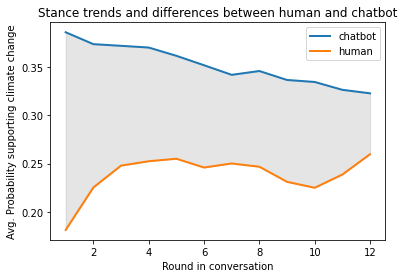

In [ ]:
plt.plot(round,mean_b,lw=2,label="chatbot")
plt.plot(round,mean_h,lw=2,label="human")

plt.fill_between(round, mean_h,mean_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting climate change")
plt.title("Stance trends and differences between human and chatbot")
plt.legend()
plt.show()

In [ ]:
result_1 = stance[stance["index"]==3290]
result_1

,index,round,text_x,stance_x,Not support_x,Support_x,text_y,stance_y,Not support_y,Support_y
13560,3290,1,I believe climate change happening future gene...,1,0.407483,0.575991,You told believe climate change cause problems...,1,0.235638,0.748395
13561,3290,2,There always difference opinion people science...,0,0.765694,0.167399,What evidence temperature Earth risen,0,0.788465,0.201330
13562,3290,3,Ive read scientific articles provided results ...,0,0.760911,0.173159,In view temperature risen somewhat year How mu...,0,0.537182,0.502918
13563,3290,4,Yes studied many many years It risen much incr...,1,0.325185,0.637079,You think people die heat exhaustion similar c...,1,0.470729,0.508261
13564,3290,5,No I think humans,0,0.803747,0.165535,Okay thank time To assist please respond infor...,0,0.608900,0.340587
13565,3290,6,I think humans adapt extremely intelligent bei...,1,0.367066,0.662644,You need provide additional information belief...,0,0.651269,0.381590
13566,3290,7,Youre welcome,0,0.895296,0.067702,Thank much time I appreciate greatly,0,0.868730,0.113971


# Visualization

In [ ]:
cc_human['stance'].replace(0,'neutral',inplace=True)
cc_human['stance'].replace(1,'support',inplace=True)
cc_human['stance'].replace(-1,'against',inplace=True)
cc_human['stance'].replace(2,'factual news',inplace=True)

In [ ]:
cc_human.head()

,Unnamed: 0,Unnamed: 0.1,mod,index,round,text,stance,Not support,Support
0,0,1,1,1,1,HI,0,0.886658,0.086921
1,1,2,2,1,2,Information climate change GPT3,0,0.676523,0.331322
2,2,3,3,1,3,Nice one,0,0.632331,0.348099
3,3,4,4,1,4,meet,0,0.865277,0.097339
4,4,5,5,1,5,GPT3,0,0.763441,0.250254


In [ ]:
cc_bot['stance'].replace(0,'neutral',inplace=True)
cc_bot['stance'].replace(1,'support',inplace=True)
cc_bot['stance'].replace(-1,'against',inplace=True)
cc_bot['stance'].replace(2,'factual news',inplace=True)

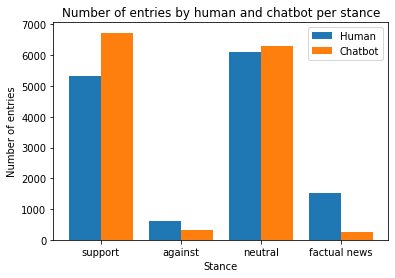

In [ ]:
import matplotlib.pyplot as plt 
  
X = ['support','against','neutral','factual news']
humans = [5326,606,6107,1528]
bots = [6731,308,6288,240]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, humans , 0.4, label = 'Human')
plt.bar(X_axis + 0.2, bots, 0.4, label = 'Chatbot')
  
plt.xticks(X_axis, X)
plt.xlabel("Stance")
plt.ylabel("Number of entries")
plt.title("Number of entries by human and chatbot per stance")
plt.legend()
plt.show()

In [ ]:
result = cc_human.groupby('round').agg({'Support': ['mean', 'min', 'max']})
result.reset_index(inplace=True)
result = pd.DataFrame(result)
result

round   Support                    
              mean       min       max
0      1  0.612494  0.129565  0.992385
1      2  0.659785  0.142660  0.998936
2      3  0.655444  0.112032  0.998936
3      4  0.666763  0.131320  0.997868
4      5  0.682084  0.172483  0.997868
5      6  0.678742  0.108253  0.998936
6      7  0.686495  0.093473  0.997868
7      8  0.696124  0.152259  0.994727
8      9  0.681289  0.155627  0.997959
9     10  0.676034  0.129138  0.979487
10    11  0.682454  0.115910  0.985223
11    12  0.714557  0.202293  0.982272

In [ ]:
result_b = cc_bot.groupby('round').agg({'Support': ['mean', 'min', 'max']})
result_b.reset_index(inplace=True)
result_b = pd.DataFrame(result_b)
result_b

round   Support                    
              mean       min       max
0      1  0.723324  0.246860  0.997827
1      2  0.803472  0.263285  0.997614
2      3  0.808714  0.243504  0.996849
3      4  0.807308  0.288559  0.998547
4      5  0.813179  0.130885  0.997572
5      6  0.812525  0.212613  0.997827
6      7  0.802822  0.291295  0.997487
7      8  0.801562  0.342734  0.995440
8      9  0.799463  0.299489  0.998379
9     10  0.801336  0.399373  0.997208
10    11  0.802938  0.384810  0.995817
11    12  0.808331  0.255454  0.994074

In [ ]:
len(blm_human)

12644

In [ ]:
# make data
round = result["round"]

result = result["Support"]
min_h = result['min']
max_h = result["max"]
mean_h = result["mean"]

result_b = result_b["Support"]
min_b = result_b['min']
max_b = result_b["max"]
mean_b = result_b["mean"]

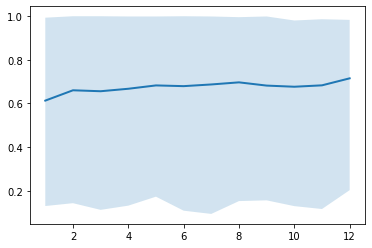

In [ ]:
# plot
fig, ax = plt.subplots()

ax.fill_between(round, min, max, alpha=.2, linewidth=0)
ax.plot(round,mean, linewidth=2)

#ax.set(xlim=(1, 12), xticks=np.arange(1, 12), ylim=(-2, 2), yticks=np.arange(-2, 2))

plt.show()

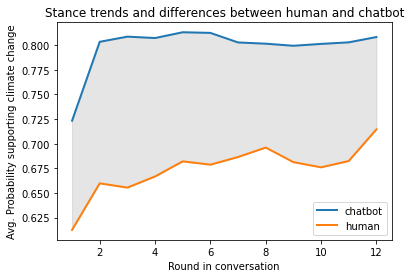

In [ ]:
plt.plot(round,mean_b,lw=2,label="chatbot")
plt.plot(round,mean_h,lw=2,label="human")

plt.fill_between(round, mean_h,mean_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting climate change")
plt.title("Stance trends and differences between human and chatbot")
plt.legend()
plt.show()

# Model - BLM

Some notes about coding BLM support vs. not support:
Support:
- Explicitily said I support BLM
- Explicitily proposed to join or encourage the other one in conversation to make contributions to BLM. e.g., let's join the next protest in Chicago.
- State positively about BLM facts or BLM, e.g., "BLM is a movement that calls for justice and more transparent laws." "I don't believe BLM should be tagged as terrorism".
- State history facts that backs BLM: e.g., slave trade, Lincoln, etc
- Counterarguing with BLM counterarguments. e.g., "I think people did not get the point when they say BLM means other lives doesn't matter".

Not support:
- Explicitly expressed against BLM. e.g., they are riots, they do harm to society, there are no racism in the US
- State neutral facts about BLM movement without judgements. e.g., "The movement is started by Alicia Garza in 2013", "The next protest will be in Chicago", "The movement start with xx event".
- Unrelated contents like greetings or off-topic talks

In [ ]:
blm = pd.read_csv("blm_manualcoding.csv",encoding = 'latin1')
blm = blm.dropna(subset=['text']) # remove any empty tweets

# cleaning the raw text data
blm['text'] = blm['text'].apply(clean_text)

In [ ]:
from keras.utils import pad_sequences

ImportError: ignored

In [ ]:
len(blm)

1742

In [ ]:
# isolate label and text
y = blm['pro']
#y += 1
X_data = blm['text']

# splitting into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size= 0.1, random_state = 1)

# Setup model parameters
EMBEDDING_FILE = "glove.42B.300d.txt" # path to embedding file 
max_features = 2800                           # we are only interested in top 50k most frequently used words
maxlen = 200                                   # tweets longer than 150 words will be truncated otherwise padded
embed_size = 300                               # size of each vector (must match the size of the glove embedding)

In [ ]:
# tokenize training and testing data
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_tr = tokenizer.texts_to_sequences(X_train)
X_tr = sequence.pad_sequences(X_tr, maxlen=maxlen)
X_ts = tokenizer.texts_to_sequences(X_test)
X_ts = sequence.pad_sequences(X_ts, maxlen=maxlen)

# loading the embedding file (may take some time)
embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
  for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

word_index = tokenizer.word_index

In [ ]:
# prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
  if i >= max_features:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

In [ ]:
y_tr_one = get_onehot(y_train,2)
y_ts_one = get_onehot(y_test,2) 

In [ ]:
# creating the model
gru_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(gru_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, reset_after=True, recurrent_activation='sigmoid'))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
gru_output = Dense(2, activation="sigmoid")(x)
gru_model = Model(gru_input, gru_output)
gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# training parameters
epochs = 20 
batch_size = 128
patience = 4    # for early stopping
file_path="weights/gru_final.hdf5" # where to save the best model weights

# creating checkpoint to save the model
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)
callbacks_list = [checkpoint, early] #early

# training the model
gru_model.fit(X_tr, y_tr_one, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

# loading the best weights
gru_model.load_weights(file_path)

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8617
Epoch 1: val_loss improved from inf to 0.37261, saving model to weights/gru_final.hdf5
12/12 [==============================] - 21s 1s/step - loss: 0.4671 - accuracy: 0.8617 - val_loss: 0.3726 - val_accuracy: 0.8726
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8709
Epoch 2: val_loss improved from 0.37261 to 0.28750, saving model to weights/gru_final.hdf5
12/12 [==============================] - 15s 1s/step - loss: 0.3215 - accuracy: 0.8709 - val_loss: 0.2875 - val_accuracy: 0.9045
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.8894
Epoch 3: val_loss improved from 0.28750 to 0.22705, saving model to weights/gru_final.hdf5
12/12 [==============================] - 15s 1s/step - loss: 0.2583 - accuracy: 0.8894 - val_loss: 0.2271 - val_accuracy: 0.9236
Epoch 4/20
12/12 [==============================] - ETA: 0s - 

In [ ]:
class_prob = gru_model.predict(X_ts)
class_pred = np.argmax(class_prob,axis=1)

cm = confusion_matrix(y_test,class_pred)
cm

6/6 [==============================] - 2s 218ms/step


array([[145,   4],
       [  7,  19]])

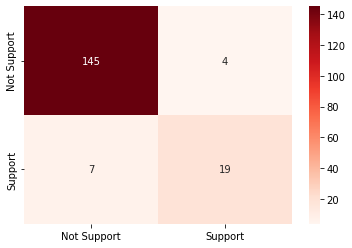

In [ ]:
classes = ['Not Support','Support']
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
sn.heatmap(df_cm, annot=True,cmap='Reds', fmt='g')

In [ ]:
TP = 19
FP = 4
TN = 145
FN = 7

prec = TP / (FP + TP)
recall = TP / (FN + TP)
accu = (TP + TN)/(TP + FN + TN + FP)
f1= 2* prec * recall/(prec + recall)

print('Precision Score: %.3f' % prec, 
      'Recall Score: %.3f' % recall, 
      'Accuracy Score: %.3f' %accu, 
      'F1 Score: %.3f' %f1 )

Precision Score: 0.826 Recall Score: 0.731 Accuracy Score: 0.937 F1 Score: 0.776


In [ ]:
blm_human = pd.read_csv("conv_blm_human.csv",encoding = 'latin1')
blm_human = blm_human.dropna(subset=['text']) # remove any empty

# cleaning the raw text data
blm_human['text'] = blm_human['text'].apply(clean_text)

X_blm_human = blm_human['text']
tokenizer_c = text.Tokenizer(num_words=max_features)
tokenizer_c.fit_on_texts(list(X_blm_human))

X_ch = tokenizer_c.texts_to_sequences(X_blm_human)
X_ch = pad_sequences(X_ch, maxlen=maxlen)

class_prob_h = gru_model.predict(X_ch)
class_pred_h = np.argmax(class_prob_h,axis=1)
#class_pred_h -=1

df_class_prob_h = pd.DataFrame(class_prob_h, columns = ['Not support','Support'])

blm_human['stance'] = class_pred_h.tolist()
blm_human = pd.concat([blm_human, df_class_prob_h], axis=1)
blm_human.head(n=10)

blm_human.to_csv("blm_human_machinecode.csv")

396/396 [==============================] - 84s 212ms/step


In [ ]:

blm_bot = pd.read_csv("conv_blm_bot.csv",encoding = 'latin1')
blm_bot = blm_bot.dropna(subset=['text']) # remove any empty

# cleaning the raw text data
blm_bot['text'] = blm_bot['text'].apply(clean_text)

X_blm_bot = blm_bot['text']
tokenizer_c = text.Tokenizer(num_words=max_features)
tokenizer_c.fit_on_texts(list(X_blm_bot))

X_ch = tokenizer_c.texts_to_sequences(X_blm_bot)
X_ch = sequence.pad_sequences(X_ch, maxlen=maxlen)

class_prob_h = gru_model.predict(X_ch)
class_pred_h = np.argmax(class_prob_h,axis=1)
#class_pred_h -=1

df_class_prob_h = pd.DataFrame(class_prob_h, columns = ['Not support','Support'])

blm_bot['stance'] = class_pred_h.tolist()
blm_bot = pd.concat([blm_bot, df_class_prob_h], axis=1)
blm_bot.head(n=10)

blm_bot.to_csv("blm_bot_machinecode.csv")

In [ ]:

blm_human = pd.read_csv("/content/blm_human_machinecode.csv")
blm_bot = pd.read_csv("/content/blm_bot_machinecode.csv")


In [ ]:
stance = blm_human.merge(blm_bot, on=['index', 'round'])
stance=stance.drop(columns=['Unnamed: 0_x','Unnamed: 0_y',"Unnamed: 0.1_x","Unnamed: 0.1_y"])
stance.tail()

,index,round,text_x,stance_x,Not support_x,Support_x,text_y,stance_y,Not support_y,Support_y
12639,3289,8,It important movement,0,0.929706,0.074433,I support black lives matter,1,0.438863,0.621812
12640,3289,9,The principles Black lives Movement empathy re...,0,0.677157,0.312747,Im sorry I information,0,0.834752,0.209474
12641,3289,10,Are clear,0,0.933771,0.041077,yes,0,0.965678,0.030390
12642,3289,11,I think clear wellknown topic,0,0.950095,0.028591,thank information I respect opinion topic,0,0.630506,0.408448
12643,3289,12,Thank patient listening,0,0.921258,0.051119,help,0,0.956142,0.041377


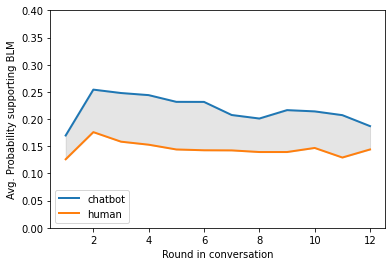

In [ ]:
#A general picture
result = blm_human.groupby('round').agg({'Support': ['mean', 'min', 'max']})
result.reset_index(inplace=True)
result = pd.DataFrame(result)

result_blm_b = blm_bot.groupby('round').agg({'Support': ['mean', 'min', 'max']})
result_blm_b.reset_index(inplace=True)
result_blm_b = pd.DataFrame(result_blm_b)

round = result["round"]

result = result["Support"]
min_blm_h = result['min']
max_blm_h = result["max"]
mean_blm_h = result["mean"]

result_blm_b = result_blm_b["Support"]
min_blm_b = result_blm_b['min']
max_blm_b = result_blm_b["max"]
mean_blm_b = result_blm_b["mean"]

plt.plot(round,mean_blm_b,lw=2,label="chatbot")
plt.plot(round,mean_blm_h,lw=2,label="human")
plt.ylim(0,0.4)

plt.fill_between(round, mean_blm_h,mean_blm_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting BLM")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend(loc = 3)
plt.show()

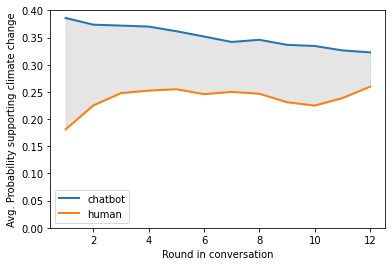

In [ ]:
cc_human = pd.read_csv("/content/cc_human_machinecode.csv")
cc_bot = pd.read_csv("/content/cc_bot_machinecode.csv")
cc_bot["stance"]+=1

stance = cc_human.merge(cc_bot, on=['index', 'round'])
stance=stance.drop(columns=['Unnamed: 0_x', 'mod','Unnamed: 0_y',"Unnamed: 0.1_x","Unnamed: 0.1_y"])
stance.tail()

result = cc_human.groupby('round').agg({'Support': ['mean', 'min', 'max']})
result.reset_index(inplace=True)
result = pd.DataFrame(result)

result_b = cc_bot.groupby('round').agg({'Support': ['mean', 'min', 'max']})
result_b.reset_index(inplace=True)
result_b = pd.DataFrame(result_b)

round = result["round"]

result = result["Support"]
min_h = result['min']
max_h = result["max"]
mean_h = result["mean"]

result_b = result_b["Support"]
min_b = result_b['min']
max_b = result_b["max"]
mean_b = result_b["mean"]

plt.plot(round,mean_b,lw=2,label="chatbot")
plt.plot(round,mean_h,lw=2,label="human")
plt.ylim(0,0.4)

plt.fill_between(round, mean_h,mean_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting climate change")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend(loc=3)
plt.show()

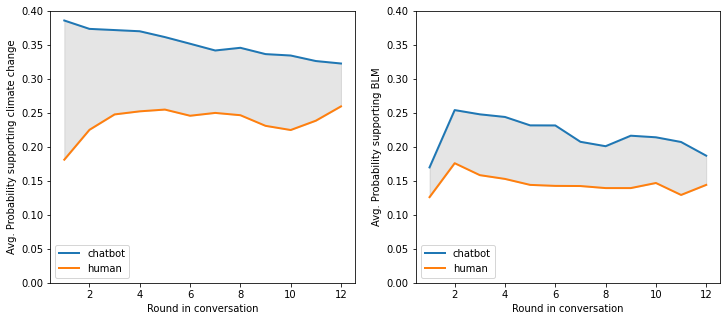

In [ ]:
plt.rcParams["figure.figsize"] = (12,5)

plt.subplot(1, 2, 2)
plt.plot(round,mean_blm_b,lw=2,label="chatbot")
plt.plot(round,mean_blm_h,lw=2,label="human")
plt.ylim(0,0.4)

plt.fill_between(round, mean_blm_h,mean_blm_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting BLM")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend(loc = 3)

plt.subplot(1, 2, 1)
plt.plot(round,mean_b,lw=2,label="chatbot")
plt.plot(round,mean_h,lw=2,label="human")
plt.ylim(0,0.4)

plt.fill_between(round, mean_h,mean_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting climate change")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend(loc=3)

plt.show()

# Percentage of support (change me mind)

In [ ]:
cc_human = pd.read_csv("/content/cc_human_machinecode.csv")
cc_bot = pd.read_csv("/content/cc_bot_machinecode.csv")
blm_human = pd.read_csv("/content/blm_human_machinecode.csv")
blm_bot = pd.read_csv("/content/blm_bot_machinecode.csv")

In [ ]:
cc_human.head()

,Unnamed: 0,Unnamed: 0.1,mod,index,round,text,stance,Not support,Support
0,0,1,1,1,1,HI,0,0.886658,0.086921
1,1,2,2,1,2,Information climate change GPT3,0,0.676523,0.331322
2,2,3,3,1,3,Nice one,0,0.632331,0.348099
3,3,4,4,1,4,meet,0,0.865277,0.097339
4,4,5,5,1,5,GPT3,0,0.763441,0.250254


In [ ]:
cc_human = cc_human[["round","stance"]]

In [ ]:
df_cc = cc_human.groupby(["round","stance"]).size().reset_index(name="Supports")
df_cc = df_cc[df_cc.stance == 1]

df_cc1 = cc_human.groupby(["round"]).size().reset_index(name="Total")

ccstancehuman = df_cc.merge(df_cc1, on=['round'])

In [ ]:
ccstancehuman["support pct"] = ccstancehuman["Supports"]/ccstancehuman["Total"]
ccstancehuman

,round,stance,Supports,Total,support pct
0,1,1,123,1693,0.072652
1,2,1,145,1693,0.085647
2,3,1,207,1693,0.122268
3,4,1,228,1693,0.134672
4,5,1,214,1693,0.126403
5,6,1,196,1693,0.115771
6,7,1,127,1023,0.124145
7,8,1,84,740,0.113514
8,9,1,50,576,0.086806
9,10,1,34,442,0.076923


In [ ]:
cc_bot = cc_bot[["round","stance"]]
df_cc = cc_bot.groupby(["round","stance"]).size().reset_index(name="Supports")
df_cc = df_cc[df_cc.stance == 0]

df_cc1 = cc_bot.groupby(["round"]).size().reset_index(name="Total")

ccstancebot = df_cc.merge(df_cc1, on=['round'])
ccstancebot["support pct"] = ccstancebot["Supports"]/ccstancebot["Total"]
ccstancebot

,round,stance,Supports,Total,support pct
0,1,0,914,1693,0.539870
1,2,0,557,1693,0.329002
2,3,0,539,1693,0.318370
3,4,0,534,1693,0.315416
4,5,0,528,1693,0.311872
5,6,0,489,1693,0.288836
6,7,0,265,1023,0.259042
7,8,0,208,740,0.281081
8,9,0,144,576,0.250000
9,10,0,123,442,0.278281


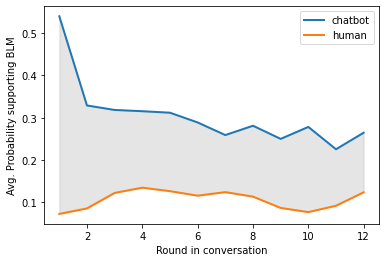

In [ ]:
round = ccstancehuman["round"]
pb_cc = ccstancebot["support pct"]
ph_cc = ccstancehuman["support pct"]

plt.plot(round,pb_cc,lw=2,label="chatbot")
plt.plot(round,ph_cc,lw=2,label="human")

plt.fill_between(round, ph_cc,pb_cc,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting BLM")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend()
plt.show()

In [ ]:
blm_human = blm_human[["round","stance"]]
df_blm = blm_human.groupby(["round","stance"]).size().reset_index(name="Supports")
df_blm = df_blm[df_blm.stance == 1]

df_blm1 = blm_human.groupby(["round"]).size().reset_index(name="Total")

blmstancehuman = df_blm.merge(df_blm1, on=['round'])
blmstancehuman["support pct"] = blmstancehuman["Supports"]/blmstancehuman["Total"]
blmstancehuman

,round,stance,Supports,Total,support pct
0,1,1,57,1594,0.035759
1,2,1,90,1594,0.056462
2,3,1,76,1594,0.047679
3,4,1,72,1594,0.045169
4,5,1,58,1594,0.036386
5,6,1,67,1594,0.042033
6,7,1,38,923,0.041170
7,8,1,20,660,0.030303
8,9,1,16,515,0.031068
9,10,1,12,393,0.030534


In [ ]:
blm_bot = blm_bot[["round","stance"]]
df_blm = blm_bot.groupby(["round","stance"]).size().reset_index(name="Supports")
df_blm = df_blm[df_blm.stance == 1]

df_blm1 = blm_bot.groupby(["round"]).size().reset_index(name="Total")

blmstancebot = df_blm.merge(df_blm1, on=['round'])
blmstancebot["support pct"] = blmstancebot["Supports"]/blmstancebot["Total"]
blmstancebot

,round,stance,Supports,Total,support pct
0,1,1,72,1594,0.045169
1,2,1,159,1594,0.099749
2,3,1,140,1594,0.087829
3,4,1,145,1594,0.090966
4,5,1,132,1594,0.082811
5,6,1,130,1594,0.081556
6,7,1,58,923,0.062839
7,8,1,37,660,0.056061
8,9,1,37,515,0.071845
9,10,1,23,393,0.058524


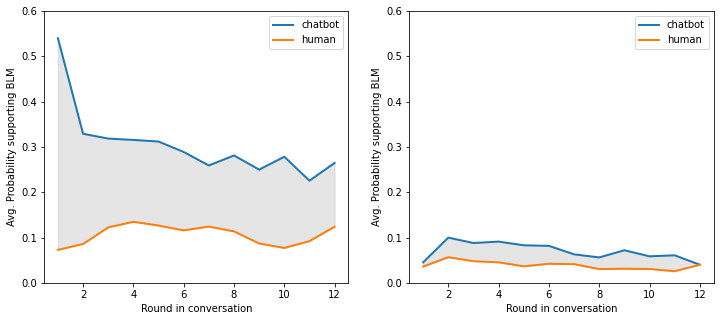

In [ ]:
plt.subplot(1, 2, 2)
round = blmstancehuman["round"]
pb = blmstancebot["support pct"]
ph = blmstancehuman["support pct"]

plt.plot(round,pb,lw=2,label="chatbot")
plt.plot(round,ph,lw=2,label="human")

plt.fill_between(round, ph,pb,color='k',alpha=.1)
plt.ylim(0,0.6)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting BLM")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend()

plt.subplot(1, 2, 1)
round = ccstancehuman["round"]
pb_cc = ccstancebot["support pct"]
ph_cc = ccstancehuman["support pct"]

plt.plot(round,pb_cc,lw=2,label="chatbot")
plt.plot(round,ph_cc,lw=2,label="human")

plt.fill_between(round, ph_cc,pb_cc,color='k',alpha=.1)
plt.ylim(0,0.6)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting BLM")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend()
plt.show()

# New visualization featuring the edu and opinion minorities

In [ ]:
cc_stances = pd.read_csv("/content/cc_stance_and_survey.csv",encoding='unicode_escape')
blm_stances = pd.read_csv("/content/blm_stance_and_survey.csv",encoding='unicode_escape')

I also want to show to readers (as I discussed it in the result section on knowledge gains): 


*   how opinion minority participants' stance on the two issues changed over time
*   how education minority participants' stance on the two issues changed over time


In [ ]:
cc_stances_edu = cc_stances[cc_stances["eduminor"] == "minor"]
blm_stances_edu = blm_stances[blm_stances["eduminor"] == "minor"]

In [ ]:
blm_stances_edu

In [ ]:
result = cc_stances_edu.groupby('round').agg({'p_s_human': ['mean', 'min', 'max']})
result.reset_index(inplace=True)
result = pd.DataFrame(result)

result_b = cc_stances_edu.groupby('round').agg({'p_s_bot': ['mean', 'min', 'max']})
result_b.reset_index(inplace=True)
result_b = pd.DataFrame(result_b)

round = result["round"]

result = result["p_s_human"]
min_h = result['min']
max_h = result["max"]
mean_h = result["mean"]

result_b = result_b["p_s_bot"]
min_b = result_b['min']
max_b = result_b["max"]
mean_b = result_b["mean"]

plt.plot(round,mean_b,lw=2,label="chatbot")
plt.plot(round,mean_h,lw=2,label="human")
plt.ylim(0,0.5)

plt.fill_between(round, mean_h,mean_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting climate change")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend(loc=3)
plt.show()

In [ ]:
result = blm_stances_edu.groupby('round').agg({'p_s_human': ['mean', 'min', 'max']})
result.reset_index(inplace=True)
result = pd.DataFrame(result)

result_blm_b = blm_stances_edu.groupby('round').agg({'p_s_bot': ['mean', 'min', 'max']})
result_blm_b.reset_index(inplace=True)
result_blm_b = pd.DataFrame(result_blm_b)

round = result["round"]

result = result["p_s_human"]
min_blm_h = result['min']
max_blm_h = result["max"]
mean_blm_h = result["mean"]

result_blm_b = result_blm_b["p_s_bot"]
min_blm_b = result_blm_b['min']
max_blm_b = result_blm_b["max"]
mean_blm_b = result_blm_b["mean"]

plt.plot(round,mean_blm_b,lw=2,label="chatbot")
plt.plot(round,mean_blm_h,lw=2,label="human")
plt.ylim(0,0.5)

plt.fill_between(round, mean_blm_h,mean_blm_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting BLM")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend(loc = 3)
plt.show()

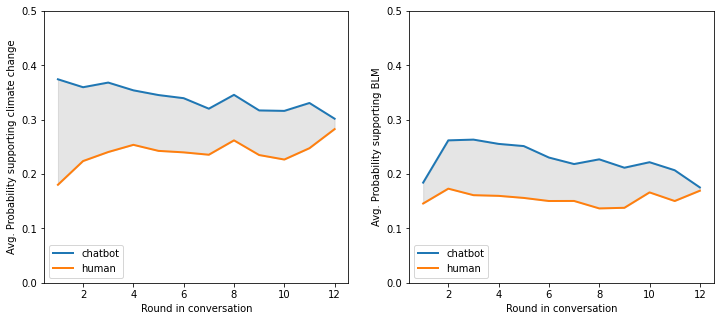

In [ ]:
plt.rcParams["figure.figsize"] = (12,5)

plt.subplot(1, 2, 2)
plt.plot(round,mean_blm_b,lw=2,label="chatbot")
plt.plot(round,mean_blm_h,lw=2,label="human")
plt.ylim(0,0.5)

plt.fill_between(round, mean_blm_h,mean_blm_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting BLM")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend(loc = 3)

plt.subplot(1, 2, 1)
plt.plot(round,mean_b,lw=2,label="chatbot")
plt.plot(round,mean_h,lw=2,label="human")
plt.ylim(0,0.5)

plt.fill_between(round, mean_h,mean_b,color='k',alpha=.1)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting climate change")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend(loc=3)

plt.show()

In [ ]:
df_cc = cc_stances_edu.groupby(["round","stance_human"]).size().reset_index(name="Support")
df_cc = df_cc[df_cc.stance_human == 1]

df_cc1 = cc_stances_edu.groupby(["round"]).size().reset_index(name="Total")

ccstancehuman = df_cc.merge(df_cc1, on=['round'])
ccstancehuman["support pct"] = ccstancehuman["Support"]/ccstancehuman["Total"]
ccstancehuman

,round,stance_human,Support,Total,support pct
0,1,1,25,373,0.067024
1,2,1,31,373,0.083110
2,3,1,39,373,0.104558
3,4,1,50,373,0.134048
4,5,1,43,373,0.115282
5,6,1,49,373,0.131367
6,7,1,25,214,0.116822
7,8,1,19,156,0.121795
8,9,1,13,121,0.107438
9,10,1,8,85,0.094118


In [ ]:
df_cc = cc_stances_edu.groupby(["round","stance_bot"]).size().reset_index(name="Support")
df_cc = df_cc[df_cc.stance_bot == 1]

df_cc1 = cc_stances_edu.groupby(["round"]).size().reset_index(name="Total")

ccstancebot = df_cc.merge(df_cc1, on=['round'])
ccstancebot["support pct"] = ccstancebot["Support"]/ccstancebot["Total"]
ccstancebot

round = ccstancehuman["round"]
pb_cc = ccstancebot["support pct"]
ph_cc = ccstancehuman["support pct"]

In [ ]:
df_blm = blm_stances_edu.groupby(["round","stance_human"]).size().reset_index(name="Support")
df_blm = df_blm[df_blm.stance_human == 1]

df_blm1 = blm_stances_edu.groupby(["round"]).size().reset_index(name="Total")

blmstancehuman = df_blm.merge(df_blm1, on=['round'])
blmstancehuman["support pct"] = blmstancehuman["Support"]/blmstancehuman["Total"]
blmstancehuman

df_blm = blm_stances_edu.groupby(["round","stance_bot"]).size().reset_index(name="Support")
df_blm = df_blm[df_blm.stance_bot == 1]

df_blm1 = blm_stances_edu.groupby(["round"]).size().reset_index(name="Total")

blmstancebot = df_blm.merge(df_blm1, on=['round'])
blmstancebot["support pct"] = blmstancebot["Support"]/blmstancebot["Total"]
blmstancebot

round = blmstancehuman["round"]
pb_blm = blmstancebot["support pct"]
ph_blm = blmstancehuman["support pct"]

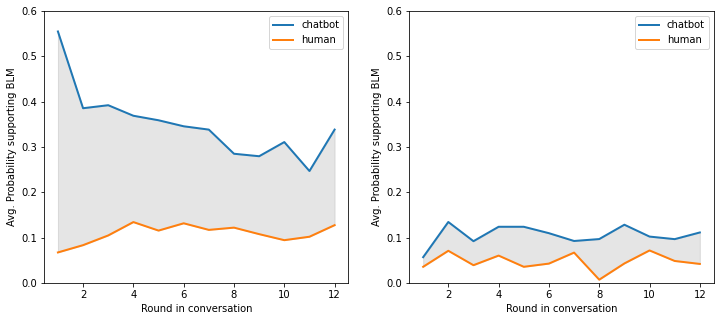

In [ ]:
plt.subplot(1, 2, 2)
round = blmstancehuman["round"]
pb = blmstancebot["support pct"]
ph = blmstancehuman["support pct"]

plt.plot(round,pb,lw=2,label="chatbot")
plt.plot(round,ph,lw=2,label="human")

plt.fill_between(round, ph,pb,color='k',alpha=.1)
plt.ylim(0,0.6)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting BLM")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend()

plt.subplot(1, 2, 1)
round = ccstancehuman["round"]
pb_cc = ccstancebot["support pct"]
ph_cc = ccstancehuman["support pct"]

plt.plot(round,pb_cc,lw=2,label="chatbot")
plt.plot(round,ph_cc,lw=2,label="human")

plt.fill_between(round, ph_cc,pb_cc,color='k',alpha=.1)
plt.ylim(0,0.6)

plt.xlabel("Round in conversation")
plt.ylabel("Avg. Probability supporting BLM")
#plt.title("Stance trends and differences between human and chatbot")
plt.legend()
plt.show()